# 0.2 Detector Evaluation and Anomaly Threshold

This notebook evaluates the trained LSTM autoencoder on the full FD001 dataset and derives an anomaly threshold. 

**Goals**

1. Load the trained detector and preprocessing artifacts.
2. Compute reconstruction errors (anomaly scores) over full engine lifetimes.
3. Visualize anomaly scores over time for sample engines.
4. Derive and persist an anomaly threshold for downstream use.

## Imports and configuration

In [2]:
import sys
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import joblib

# Make repo root importable
sys.path.insert(0, str(Path("..").resolve()))

from src.config import (
    TRAIN_FD001_PATH,
    COLS,
    SCALER_PATH,
    ARTIFACTS_INFO_PATH,
    ARTIFACTS_DIR,
    MODEL_PATH,
    SEQUENCE_LENGTH,
    HEALTHY_CYCLES,
    EMBEDDING_DIM,
)
from src.data import create_sequences
from src.model import Autoencoder

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load artifacts and model

In [3]:
if not SCALER_PATH.is_file() or not ARTIFACTS_INFO_PATH.is_file():
    raise FileNotFoundError(
        "Missing scaler or artifacts_info.json. "
        "Run `python -m src.preprocess` first."
    )

if not MODEL_PATH.is_file():
    raise FileNotFoundError(
        f"Missing detector weights at {MODEL_PATH}. "
        "Run `python -m src.train` first."
    )

print("Loading scaler and artifacts info...")
scaler = joblib.load(SCALER_PATH)

with ARTIFACTS_INFO_PATH.open("r", encoding="utf-8") as f:
    artifacts_info = json.load(f)

cols_to_scale = artifacts_info["cols_to_scale"]
n_features = len(cols_to_scale)

print(f"Number of scaled sensor features: {n_features}")
print(f"Columns to scale: {cols_to_scale}")

print("\nLoading trained detector model...")
model = Autoencoder(
    n_features=n_features,
    sequence_length=SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM,
)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Artifacts and model loaded successfully.")


Loading scaler and artifacts info...
Number of scaled sensor features: 17
Columns to scale: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_20', 'sensor_21']

Loading trained detector model...
Artifacts and model loaded successfully.
Number of scaled sensor features: 17
Columns to scale: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_20', 'sensor_21']

Loading trained detector model...
Artifacts and model loaded successfully.


## Load and scale full FD001

In [4]:
if not TRAIN_FD001_PATH.is_file():
    raise FileNotFoundError(
        f"FD001 training data not found at {TRAIN_FD001_PATH}. "
        "Check dataset setup in README."
    )

df_scaled = pd.read_csv(
    TRAIN_FD001_PATH,
    sep=r'\s+',
    header=None,
    names=COLS,
)

df_scaled.loc[:, cols_to_scale] = scaler.transform(df_scaled.loc[:, cols_to_scale])

print("--- Scaled FD001 head ---")
df_scaled.head()


--- Scaled FD001 head ---


C:\Users\bayou\AppData\Local\Temp\ipykernel_23396\3216055930.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.33333333 0.16666667 ... 0.83333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, cols_to_scale] = scaler.transform(df_scaled.loc[:, cols_to_scale])


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,0.183735,0.406802,0.309757,0.0,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,2388,100.0,0.713178,0.724662
1,1,2,0.0019,-0.0003,100.0,518.67,0.283133,0.453019,0.352633,0.0,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,2388,100.0,0.666667,0.731014
2,1,3,-0.0043,0.0003,100.0,518.67,0.343373,0.369523,0.370527,0.0,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,2388,100.0,0.627907,0.621375
3,1,4,0.0007,0.0000,100.0,518.67,0.343373,0.256159,0.331195,0.0,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,2388,100.0,0.573643,0.662386
4,1,5,-0.0019,-0.0002,100.0,518.67,0.349398,0.257467,0.404625,0.0,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,2388,100.0,0.589147,0.704502


## Compute anomaly scores over full lifetimes

### Helper for reconstruction error

In [5]:
mse_loss = nn.MSELoss(reduction="none")

def compute_sequence_errors(
    sequences: np.ndarray,
    model: Autoencoder,
    device: torch.device,
) -> np.ndarray:
    """Compute reconstruction MSE per sequence.

    Args:
        sequences: array of shape (num_sequences, sequence_length, n_features)
        model: trained autoencoder in eval mode
        device: torch device

    Returns:
        errors: array of shape (num_sequences,) with mean MSE per sequence
    """
    if sequences.size == 0:
        return np.empty((0,), dtype=np.float32)

    seq_tensor = torch.from_numpy(sequences).to(device)

    with torch.no_grad():
        reconstructed = model(seq_tensor)
        loss = mse_loss(reconstructed, seq_tensor) # shape: (num_sequences, sequence_length, n_features) because reduction="none" (per-element loss)
        errors = loss.mean(dim=(1, 2)).cpu().numpy().astype(np.float32)

    return errors


In [6]:
results = []

for unit_id, unit_df in df_scaled.groupby("unit_number", sort=False):
    unit_sequences = create_sequences(
        data_df=unit_df,
        sensor_cols=cols_to_scale,
        sequence_length=SEQUENCE_LENGTH,
    )

    if unit_sequences.shape[0] == 0:
        print(f"Skipping engine {unit_id}: not enough cycles for one sequence.")
        continue

    seq_errors = compute_sequence_errors(
        sequences=unit_sequences,
        model=model,
        device=device,
    )

    # Map each sequence error to the cycle at its last time step
    cycles = unit_df["time_in_cycles"].values[SEQUENCE_LENGTH - 1 :]

    for cycle, error in zip(cycles, seq_errors):
        results.append(
            {
                "unit_number": int(unit_id),
                "time_in_cycles": int(cycle),
                "anomaly_score": float(error),
            }
        )

results_df = pd.DataFrame(results)
results_df.head()


,unit_number,time_in_cycles,anomaly_score
0,1,30,0.004321
1,1,31,0.004262
2,1,32,0.004338
3,1,33,0.004363
4,1,34,0.004231


### Quick sanity checks

In [7]:
print(results_df.describe(include="all"))
print(f"\nTotal scored points: {len(results_df)}")
print(f"Number of engines: {results_df['unit_number'].nunique()}")


        unit_number  time_in_cycles  anomaly_score
count  17731.000000    17731.000000   17731.000000
mean      51.671197      124.150640       0.017236
std       29.283055       61.922692       0.016240
min        1.000000       30.000000       0.003241
25%       26.000000       74.000000       0.006852
50%       53.000000      118.000000       0.011139
75%       78.000000      165.000000       0.019783
max      100.000000      362.000000       0.092595

Total scored points: 17731
Number of engines: 100


## Anomaly score over engine lifetimes

We plot anomaly scores for a few engines to visually confirm that errors are low in the initial healthy region and increase as engines degrade.

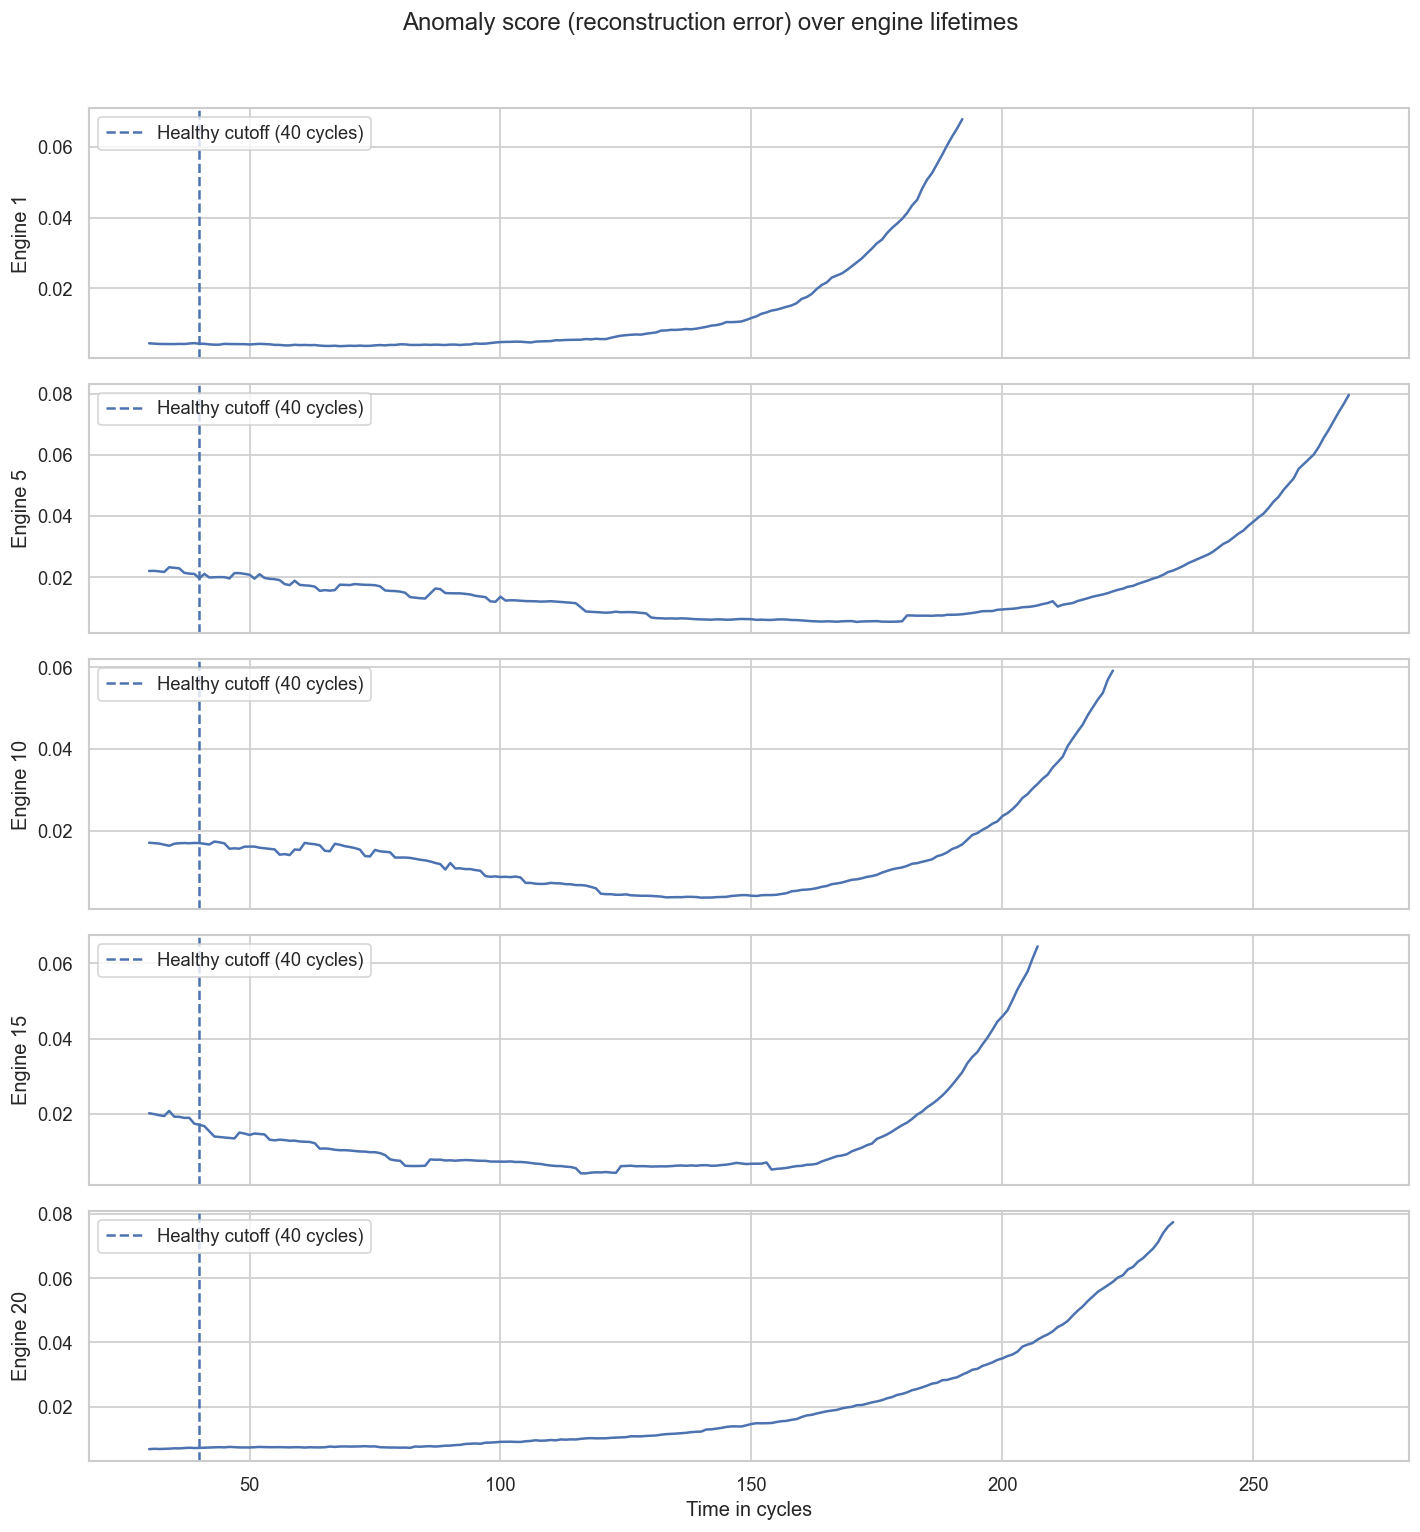

In [7]:
engines_to_plot = [1, 5, 10, 15, 20]

num_plots = len(engines_to_plot)
fig, axes = plt.subplots(num_plots, 1, figsize=(12, 2.5 * num_plots), sharex=True)

if num_plots == 1:
    axes = [axes]

for ax, unit_id in zip(axes, engines_to_plot):
    unit_results = results_df.loc[results_df["unit_number"] == unit_id]

    ax.plot(
        unit_results["time_in_cycles"],
        unit_results["anomaly_score"],
        marker=None,
    )
    ax.axvline(
        HEALTHY_CYCLES,
        linestyle="--",
        label=f"Healthy cutoff ({HEALTHY_CYCLES} cycles)",
    )
    ax.set_ylabel(f"Engine {unit_id}")
    ax.legend(loc="upper left")

axes[-1].set_xlabel("Time in cycles")
fig.suptitle(
    "Anomaly score (reconstruction error) over engine lifetimes",
    y=1.02,
)
fig.tight_layout()
plt.show()


## Threshold from healthy data

We now compute anomaly scores on the subset used as healthy training data and set the anomaly threshold as:

> mean(healthy_errors) + 3 * std(healthy_errors)

This gives a conservative cutoff while keeping the method simple and explainable.

In [8]:
# Restrict to first HEALTHY_CYCLES per engine, same rule as in training
df_healthy = df_scaled.groupby("unit_number", sort=False).head(HEALTHY_CYCLES)

healthy_sequences = create_sequences(
    data_df=df_healthy,
    sensor_cols=cols_to_scale,
    sequence_length=SEQUENCE_LENGTH,
)

healthy_errors = compute_sequence_errors(
    sequences=healthy_sequences,
    model=model,
    device=device,
)

len(healthy_errors), healthy_errors[:5]


(1100,
 array([0.00432102, 0.00426215, 0.00433784, 0.00436254, 0.00423149],
       dtype=float32))

### Visualize healthy error distribution and compute threshold

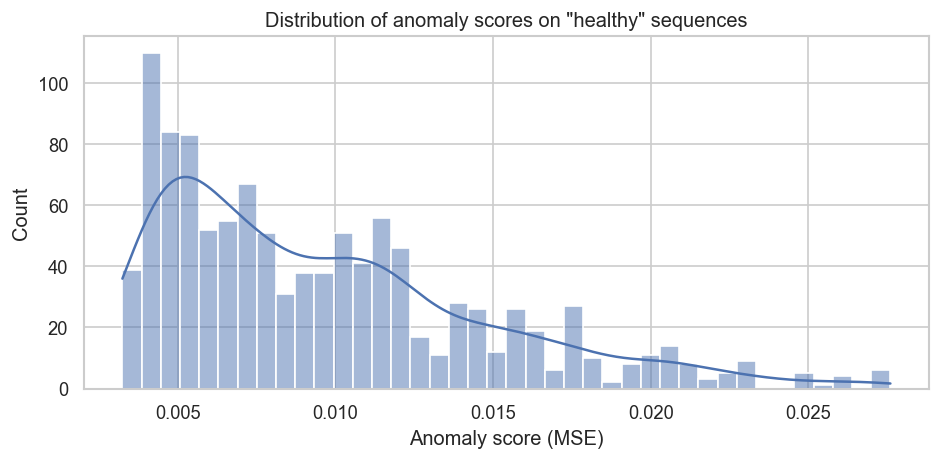

--- Anomaly threshold from healthy data ---
Mean error: 0.009640
Std error:  0.005141
Threshold (mean + 3 * std): 0.025064


In [9]:
plt.figure(figsize=(8, 4))
sns.histplot(healthy_errors, bins=40, kde=True)
plt.title('Distribution of anomaly scores on "healthy" sequences')
plt.xlabel("Anomaly score (MSE)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

mean_err = float(np.mean(healthy_errors))
std_err = float(np.std(healthy_errors))
threshold = mean_err + 3.0 * std_err

print("--- Anomaly threshold from healthy data ---")
print(f"Mean error: {mean_err:.6f}")
print(f"Std error:  {std_err:.6f}")
print(f"Threshold (mean + 3 * std): {threshold:.6f}")


### Persist threshold to artifacts_info.json

In [10]:
artifacts_info["anomaly_threshold"] = float(threshold)

with ARTIFACTS_INFO_PATH.open("w", encoding="utf-8") as f:
    json.dump(artifacts_info, f, indent=4)

print(f"Anomaly threshold saved to {ARTIFACTS_INFO_PATH}")


Anomaly threshold saved to C:\Users\bayou\OneDrive\Dokumente\projects\turbofan-mlops-pipeline\models\artifacts_info.json


### Evaluation complete

The detector has been evaluated on full FD001 lifetimes, and a data driven anomaly threshold has been written to `models/artifacts_info.json`.

Downstream components (API, RAG pipeline, UI) should read `anomaly_threshold` from that file when deciding whether a given score indicates an anomaly.
